In [1]:
import sys
import os
import platform
import importlib
import glob
import netCDF4

import numpy as np
import pandas as pd
import datetime

if platform.system() == 'Darwin':  # macOS
    base_FP = '/Users/hyunglokkim/Insync/hkim@geol.sc.edu/Google_Drive'
    cpuserver_data_FP = '/Users/hyunglokkim/cpuserver_data'
elif platform.system() == 'Linux':
    base_FP = '/home/subin/data'
    cpuserver_data_FP = '/home/subin/cpuserver_data'
else:
    base_FP = '/data'
    cpuserver_data_FP = '/data'
sys.path.append(base_FP + '/python_modules')
print(base_FP, cpuserver_data_FP)

#hydroAI libs
import HydroAI.ERA5_land as hERA5_land
import HydroAI.Grid as hGrid
import HydroAI.Plot as hPlot
import HydroAI.Data as hData
importlib.reload(hERA5_land);
importlib.reload(hPlot);
importlib.reload(hData);

# Ignore runtime warnings
import warnings
warnings.filterwarnings("ignore")

# Define your directory where to save nc files
nc_save_dir = cpuserver_data_FP + '/extracted_nc'

/home/subin/data /home/subin/cpuserver_data


## 1. Import and save ERA5_land variable

In [2]:
year = 2022
variable_name = 'swvl1'
directory = os.path.join(cpuserver_data_FP, 'ERA5/monthly/2015_2023/')
nc_file = f'{directory}/ERA5_land_{year}.nc'

In [14]:
nc_data  = netCDF4.Dataset(nc_file)
nc_lon = nc_data.variables['longitude'][:].data
nc_lat = nc_data.variables['latitude'][:].data
var_data = nc_data.variables[variable_name][:].data

# Replace Fill value into np.nan
try:
    fill_value = np.float64(nc_data.variables[variable_name]._FillValue)
    var_data[var_data == fill_value] = np.nan
except AttributeError:
    print("ERA5_land nc file has no FillValue attribute!")
nc_data.close()

print(np.shape(nc_lon))
print(np.shape(nc_lat))

nc_lon, nc_lat = hERA5_land.preprocess_lon_lat(nc_lon, nc_lat)
var_data = hERA5_land.correct_shape(var_data)

(3600,)
(1801,)


In [15]:
np.shape(nc_lat)

(1801, 3600)

In [16]:
np.shape(var_data)

(1801, 3600, 12)

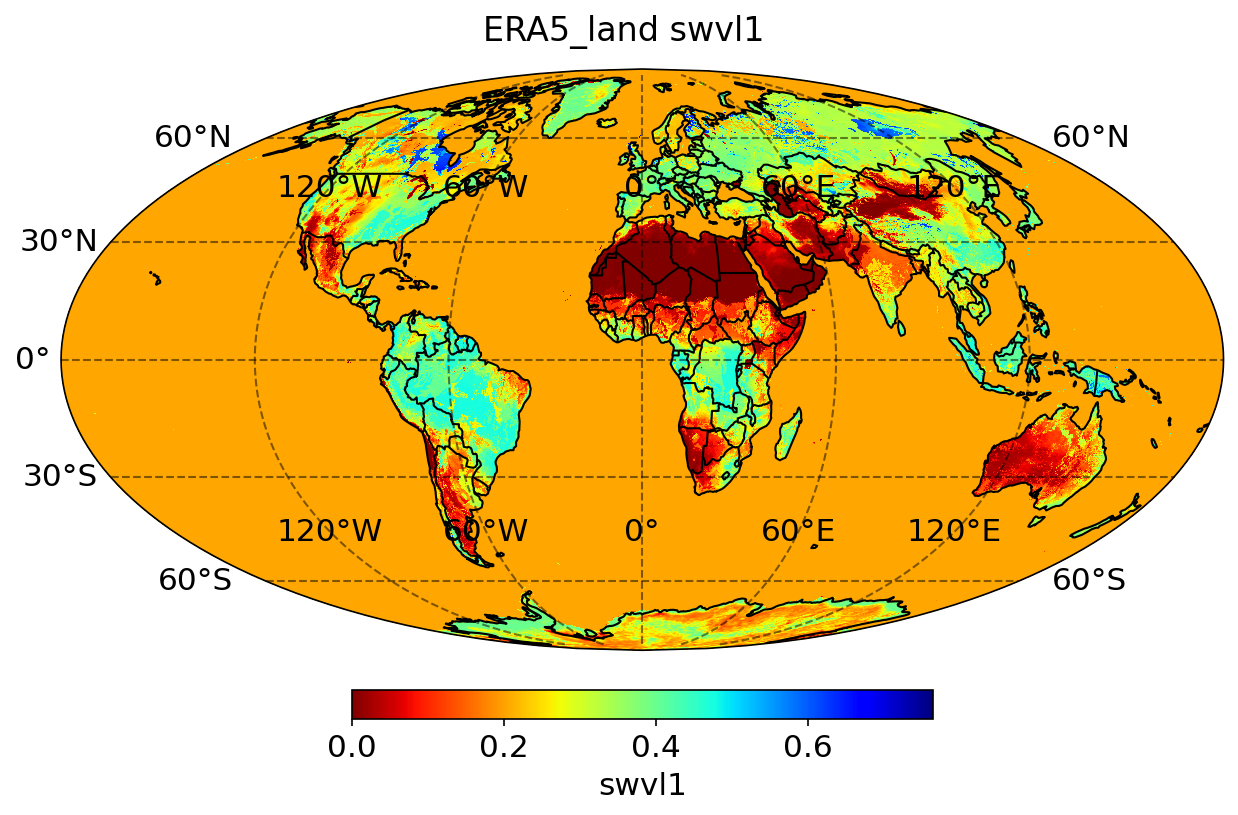

(<Figure size 1500x1500 with 2 Axes>, <GeoAxes: >)

In [17]:
# Display the map with plot_global_map
month = 12 - 1 # for index starts from 0
target = var_data
hPlot.plot_map(nc_lon, nc_lat, target[:, :, month], np.nanmin(target), np.nanmax(target), plot_title=f'ERA5_land {variable_name}', label_title=f'{variable_name}', cmap='jet_r')

## 2. Resample ERA5 data

In [21]:
target_projection = 'Noah_025'
domain_nc_file = cpuserver_data_FP+'/grids/GLDAS_NOAH_025.nc'
nc_data = netCDF4.Dataset(domain_nc_file)
domain_lat = np.flipud(nc_data.variables['lat'][:]).data
domain_lon = np.flipud(nc_data.variables['lon'][:]).data
nc_data.close()

for year in range(2015, 2023 + 1):
    directory = os.path.join(cpuserver_data_FP, 'ERA5/monthly/2015_2023/')
    nc_file = f'{directory}/ERA5_land_{year}.nc'

    nc_data  = netCDF4.Dataset(nc_file)
    nc_lon = nc_data.variables['longitude'][:].data
    nc_lat = nc_data.variables['latitude'][:].data
    nc_lon, nc_lat = hERA5_land.preprocess_lon_lat(nc_lon, nc_lat)

    variables_list = list(nc_data.variables.keys())
    remove_set = {'longitude', 'latitude', 'time'}
    variables_list = [i for i in variables_list if i not in remove_set]
    print(variables_list)

    data_vars = {}
    for var in variables_list:
        variable_name = f"{var}"
        var_data = nc_data.variables[variable_name][:].data
        var_data = hERA5_land.correct_shape(var_data)

        try:
            # Replace Fill value into np.nan
            fill_value = np.float64(nc_data.variables[var]._FillValue)
            var_data[var_data == fill_value] = np.nan
        except AttributeError:
            print("ERA5_land nc file has no FillValue attribute!")

        resampled_data  = hData.Resampling_forloop(domain_lon, domain_lat, nc_lon, nc_lat, var_data)
        data_vars[variable_name] = resampled_data
    nc_data.close()

    # Save to NetCDF file
    nc_file_name = os.path.join(nc_save_dir, f'ERA5_land_{year}_R_{target_projection}.nc')
    hData.create_netcdf_file(
        nc_file    = nc_file_name,
        latitude   = domain_lat,
        longitude  = domain_lon,
        **data_vars
    )
    print(f"NetCDF file created: {nc_file_name}")

['u10', 'v10', 'd2m', 't2m', 'evabs', 'evaow', 'evatc', 'evavt', 'fal', 'lai_hv', 'lai_lv', 'pev', 'ro', 'src', 'skt', 'asn', 'snowc', 'rsn', 'sde', 'sd', 'es', 'sf', 'smlt', 'stl1', 'stl2', 'stl3', 'stl4', 'ssro', 'slhf', 'ssr', 'str', 'sp', 'sro', 'sshf', 'ssrd', 'strd', 'tsn', 'e', 'tp', 'swvl1', 'swvl2', 'swvl3', 'swvl4']


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:33<00:00,  2.77s/it]


NetCDF file /home/subin/cpuserver_data/extracted_nc/ERA5_land_2015_R_Noah_025.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/ERA5_land_2015_R_Noah_025.nc
['u10', 'v10', 'd2m', 't2m', 'evabs', 'evaow', 'evatc', 'evavt', 'fal', 'lai_hv', 'lai_lv', 'pev', 'ro', 'src', 'skt', 'asn', 'snowc', 'rsn', 'sde', 'sd', 'es', 'sf', 'smlt', 'stl1', 'stl2', 'stl3', 'stl4', 'ssro', 'slhf', 'ssr', 'str', 'sp', 'sro', 'sshf', 'ssrd', 'strd', 'tsn', 'e', 'tp', 'swvl1', 'swvl2', 'swvl3', 'swvl4']


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:31<00:00,  2.60s/it]


NetCDF file /home/subin/cpuserver_data/extracted_nc/ERA5_land_2016_R_Noah_025.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/ERA5_land_2016_R_Noah_025.nc
['u10', 'v10', 'd2m', 't2m', 'evabs', 'evaow', 'evatc', 'evavt', 'fal', 'lai_hv', 'lai_lv', 'pev', 'ro', 'src', 'skt', 'asn', 'snowc', 'rsn', 'sde', 'sd', 'es', 'sf', 'smlt', 'stl1', 'stl2', 'stl3', 'stl4', 'ssro', 'slhf', 'ssr', 'str', 'sp', 'sro', 'sshf', 'ssrd', 'strd', 'tsn', 'e', 'tp', 'swvl1', 'swvl2', 'swvl3', 'swvl4']


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:31<00:00,  2.60s/it]


NetCDF file /home/subin/cpuserver_data/extracted_nc/ERA5_land_2017_R_Noah_025.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/ERA5_land_2017_R_Noah_025.nc
['u10', 'v10', 'd2m', 't2m', 'evabs', 'evaow', 'evatc', 'evavt', 'fal', 'lai_hv', 'lai_lv', 'pev', 'ro', 'src', 'skt', 'asn', 'snowc', 'rsn', 'sde', 'sd', 'es', 'sf', 'smlt', 'stl1', 'stl2', 'stl3', 'stl4', 'ssro', 'slhf', 'ssr', 'str', 'sp', 'sro', 'sshf', 'ssrd', 'strd', 'tsn', 'e', 'tp', 'swvl1', 'swvl2', 'swvl3', 'swvl4']


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:30<00:00,  2.51s/it]


NetCDF file /home/subin/cpuserver_data/extracted_nc/ERA5_land_2018_R_Noah_025.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/ERA5_land_2018_R_Noah_025.nc
['u10', 'v10', 'd2m', 't2m', 'evabs', 'evaow', 'evatc', 'evavt', 'fal', 'lai_hv', 'lai_lv', 'pev', 'ro', 'src', 'skt', 'asn', 'snowc', 'rsn', 'sde', 'sd', 'es', 'sf', 'smlt', 'stl1', 'stl2', 'stl3', 'stl4', 'ssro', 'slhf', 'ssr', 'str', 'sp', 'sro', 'sshf', 'ssrd', 'strd', 'tsn', 'e', 'tp', 'swvl1', 'swvl2', 'swvl3', 'swvl4']


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:30<00:00,  2.52s/it]


NetCDF file /home/subin/cpuserver_data/extracted_nc/ERA5_land_2019_R_Noah_025.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/ERA5_land_2019_R_Noah_025.nc
['u10', 'v10', 'd2m', 't2m', 'evabs', 'evaow', 'evatc', 'evavt', 'fal', 'lai_hv', 'lai_lv', 'pev', 'ro', 'src', 'skt', 'asn', 'snowc', 'rsn', 'sde', 'sd', 'es', 'sf', 'smlt', 'stl1', 'stl2', 'stl3', 'stl4', 'ssro', 'slhf', 'ssr', 'str', 'sp', 'sro', 'sshf', 'ssrd', 'strd', 'tsn', 'e', 'tp', 'swvl1', 'swvl2', 'swvl3', 'swvl4']


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:30<00:00,  2.54s/it]


NetCDF file /home/subin/cpuserver_data/extracted_nc/ERA5_land_2020_R_Noah_025.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/ERA5_land_2020_R_Noah_025.nc
['u10', 'v10', 'd2m', 't2m', 'evabs', 'evaow', 'evatc', 'evavt', 'fal', 'lai_hv', 'lai_lv', 'pev', 'ro', 'src', 'skt', 'asn', 'snowc', 'rsn', 'sde', 'sd', 'es', 'sf', 'smlt', 'stl1', 'stl2', 'stl3', 'stl4', 'ssro', 'slhf', 'ssr', 'str', 'sp', 'sro', 'sshf', 'ssrd', 'strd', 'tsn', 'e', 'tp', 'swvl1', 'swvl2', 'swvl3', 'swvl4']


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:30<00:00,  2.55s/it]


NetCDF file /home/subin/cpuserver_data/extracted_nc/ERA5_land_2021_R_Noah_025.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/ERA5_land_2021_R_Noah_025.nc
['u10', 'v10', 'd2m', 't2m', 'evabs', 'evaow', 'evatc', 'evavt', 'fal', 'lai_hv', 'lai_lv', 'pev', 'ro', 'src', 'skt', 'asn', 'snowc', 'rsn', 'sde', 'sd', 'es', 'sf', 'smlt', 'stl1', 'stl2', 'stl3', 'stl4', 'ssro', 'slhf', 'ssr', 'str', 'sp', 'sro', 'sshf', 'ssrd', 'strd', 'tsn', 'e', 'tp', 'swvl1', 'swvl2', 'swvl3', 'swvl4']


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:32<00:00,  2.67s/it]


NetCDF file /home/subin/cpuserver_data/extracted_nc/ERA5_land_2022_R_Noah_025.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/ERA5_land_2022_R_Noah_025.nc
['u10', 'v10', 'd2m', 't2m', 'fal', 'lai_hv', 'lai_lv', 'src', 'skt', 'asn', 'snowc', 'rsn', 'sde', 'sd', 'stl1', 'stl2', 'stl3', 'stl4', 'sp', 'tsn', 'swvl1', 'swvl2', 'swvl3', 'swvl4']


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:30<00:00,  2.52s/it]


NetCDF file /home/subin/cpuserver_data/extracted_nc/ERA5_land_2023_R_Noah_025.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/ERA5_land_2023_R_Noah_025.nc


In [30]:
def read_resampled_nc_file(year, variable_name, Resampled_product):  
    nc_file = f'{nc_save_dir}/ERA5_land_{year}_R_{Resampled_product}.nc'
    
    nc_data  = netCDF4.Dataset(nc_file)
    nc_var  = nc_data.variables[variable_name][:].data
    nc_lon = nc_data.variables['longitude'][:].data
    nc_lat = nc_data.variables['latitude'][:].data
    nc_data.close()
    print(np.shape(nc_var))

    return nc_var, nc_lon, nc_lat

(600, 1440, 12)


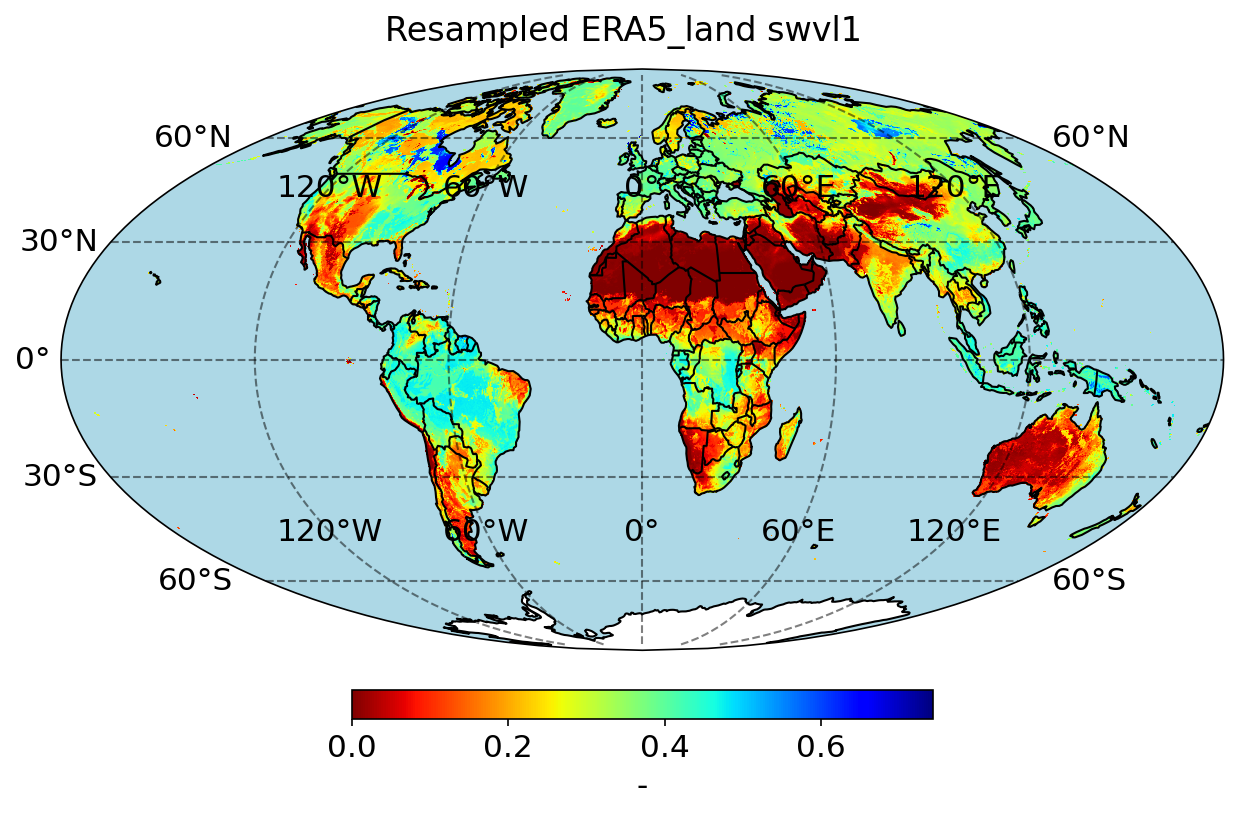

(<Figure size 1500x1500 with 2 Axes>, <GeoAxes: >)

In [31]:
# Resampled by Noah_025
month = 12 - 1 # for index starts from 0
variable_name = 'swvl1'
Resampled_data, Resampled_lon, Resampled_lat = read_resampled_nc_file(2021, variable_name, 'Noah_025')
target = Resampled_data[:,:,month]
hPlot.plot_map(Resampled_lon, Resampled_lat, target, np.nanmin(target), np.nanmax(target), plot_title=f'Resampled ERA5_land {variable_name}', label_title='-', cmap='jet_r')